# Assignment 1 - k-Armed Bandit Problem
## Special Topics: Reinforcement Learning KV
### WS 2018


<br>
<center><img src="https://conversionxl.com/wp-content/uploads/2015/09/multiarmedbandit.jpg">
<br>
</center>

---

# Definition of the Problem
Problem Description:
- We repeat choosing among k different actions (options)
- After each action you receive a numeric reward originating from a (stationary) probability distribution
- Our objective: maximize expected total reward over time by concentrating on beneficial actions

The particular problem we are facing here is defined as follows:
- A set of 2000 randomly generated $10$-armed bandit problems
- The action values $q_*(a)$ are sampled from $\mathcal{N}(0,\,1)$
- The actual rewards $R_t$ are sampled from $\mathcal{N}(q_*(a),\,1)$

## Python Imports

As you will probably notice below we also explicitly import the packages numpy and matplotlib to directly access their functionality.

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

# set some colors for plots
cmap = ['m', 'b', 'g', 'k', 'orange', 'c']

# we set the number of choices to 10
N_ACTIONS = 10

# we also fix a seed for reproducing our results
np.random.seed(4711)

# interactive plotting "on"
plt.ion()

## Definition of k-Armed Bandit Problem
In this section we implement the actual bandit problem.

In [2]:
class kArmedBandit(object):
    """
    Specifies a k-armed bandit problem
    
    The agent has to choose from k different actions.
    Taking an action yields a numeric reward specified by a stationary probability distribution.
    """
    
    def __init__(self, k=10):
        """ Constructor """
        
        # sample action values from gaussian with mean 0 and standard deviation 1
        self.q_star = np.zeros(k)
        for a in range(k):
            self.q_star[a] = np.random.randn()
    
    def step(self, action):
        """
        Take one step following the given action.
        
        Parameters
        ----------
           @action: action id (integer in [0, k[)
        
        Returns
        -------
            the reward for taking this action.
        """
        Ri = self.q_star[action] + np.random.randn()
        return Ri

## Visualization of One Problem Instance
This section is just for visualizing the problem instances we are facing.
For this purpose we generate one instance of the problem and uniformly select actions to get a notion of the underlying stationary probability distribution.

In [3]:
# initialize bandit problem with N_ACTIONS actions
bandit_instance = kArmedBandit(k=N_ACTIONS)

In [4]:
# iterate actions and select each one 1000 times
action_rewards = np.zeros((N_ACTIONS, 1000))
for action in range(N_ACTIONS):
    
    # choose each action several times and recive reward
    # (this will hopefully reveal the underlying distribution)
    for i_step in range(action_rewards.shape[1]):
        r = bandit_instance.step(action)
        action_rewards[action, i_step] = r

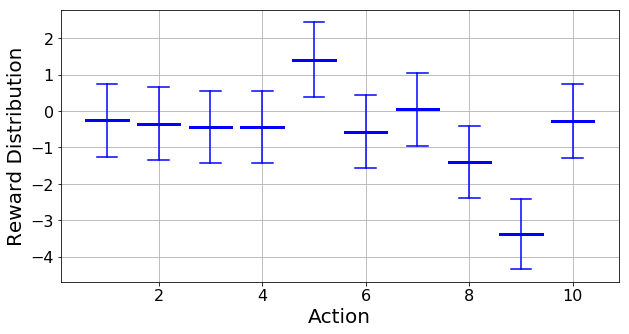

In [5]:
# vizualize problem instance

# compute means and standard deviations
means = action_rewards.mean(axis=1)
stds = action_rewards.std(axis=1)

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
for i in range(N_ACTIONS):
    plt.plot([i + 0.6, i + 1.4], 2 * [means[i]], 'b-', linewidth=3)
    plt.plot([i + 0.8, i + 1.2], 2 * [means[i] + stds[i]], 'b-', linewidth=1.5)
    plt.plot([i + 0.8, i + 1.2], 2 * [means[i] - stds[i]], 'b-', linewidth=1.5)
    plt.plot(2 * [i + 1], [means[i] - stds[i], means[i] + stds[i]], 'b-', linewidth=1.5)
plt.xlabel("Action", fontsize=20)
plt.ylabel("Reward Distribution", fontsize=20)
ax.tick_params(labelsize=16)
plt.grid('on')
plt.show()

# Comparison of Standard Algorithms
Your task in this exercise is to compare the bandit algorithms listed below on our standard testbed e.g. the 10-armed bandit problem.
* Iterative Sample Average Method
* Greedy vs. epsilon-Greedy Action Selection
* Optimistic Initial Values
* Gradient Bandit Algorithms

## Random Action Selection Baseline
Implementation of a random action selection baseline. This should just serve as a template for you to implement the much more intelligent bandit algorithms below.

In [6]:
class RandomBaseline(object):
    """
    Random Action Selection
    
    Parameters
    ----------
        @k: number of possible actions (integer)
    """
    
    def __init__(self, k=10):
        """ Constructor """
        
        # number of possible actions
        self.k = k
    
    def choose_action(self):
        """ Action selection """
        
        # choose random action
        At = np.random.choice(self.k)
        return At
    
    def update_estimates(self, action, reward):
        """ update action value estimate """
        # nothing todo here
        pass

## Incremental Sample Average Method (5 points)
Implementation of the Sample Average Method. The algorithm is parametrized by the number of actions and a probability $\epsilon$ of picking a random action instead of following the policy.

In [7]:
class IncrementalSampleAverageMethod(object):
    """
    Incremental Implemenation of Sample Average Method

    Parameters
    ----------
        @k: number of possible actions (integer)
        @epsilon: probability for selecting a random action (float in [0, 1])
        @initial_value: initial action value estimate (can be used of optimistic initial values)
    """

    def __init__(self, k=10, epsilon=0.0):
        """ Constructor """
        if isinstance(k, int) and k > 0:
            self.k = k
        else:
            raise ValueError('k must be a positive Integer')
        if 0 <= epsilon <= 1:
            self.eps = epsilon
        else:
            raise ValueError('Epsilon must be between 0 and 1')
        # Action estimates
        self.Qa = np.zeros(k)
        # Number of times actions have been selected
        self.Na = np.zeros(k)

    def choose_action(self):
        """ Action selection """
        if self.eps > 0.0 and np.random.uniform() <= self.eps:
            # Random selection
            At = np.random.choice(self.k)
        else:
            # Greedy selection: action with max estimate, random tie break
            At = np.random.choice(np.flatnonzero(self.Qa == self.Qa.max()))
        return At

    def update_estimates(self, action, reward):
        """ update action value estimate """
        self.Na[action] += 1
        Qa_update = (1/self.Na[action]) * (reward - self.Qa[action])
        self.Qa[action] += Qa_update

## Optimistic Initial Values (2 points)
Change the Implementation of the Sample Average Method from above to use Optimistic Initial Values for exploration. The algorithm is parametrized by the number of actions and a set of initial values initialize the value estimates.
The latter is required for Optimistic Initial Values which allows to encourage exploration.

In [8]:
class OptimisticInitialValues(IncrementalSampleAverageMethod):
    """
    Incremental Implemenation of Optimisitc Initial Values
    Extends IncrementalSampleAverageMethod

    Parameters
    ----------
        @k: number of possible actions (integer)
        @initial_value: initial action value estimate
    """

    def __init__(self, k=10, epsilon=0.0, initial_value=0.0):
        """ Constructor """
        if isinstance(k, int) and k > 0:
            self.k = k
        else:
            raise ValueError('k must be a positive Integer')
        if 0 <= epsilon <= 1:
            self.eps = epsilon
        else:
            raise ValueError('Epsilon must be between 0 and 1')
        # Action estimates with optimistic initial value
        self.Qa = np.full(k, initial_value)
        # Number of times actions have been selected
        self.Na = np.zeros(k)

    # Other methods are inherited from parent (IncrementalSampleAverageMethod)

## Gradient Bandit Algorithm (5 points)
Implementation of the Gradient Bandit Algorithm. The algorithm is parametrized by the number of actions and step size $\alpha$.

In [9]:
class GradientBandit(object):
    """
    Gradient Bandit Method

    Parameters
    ----------
        @k: number of possible actions (integer)
        @alpha: step-size parameter (float)
    """

    def __init__(self, k=10, alpha=0.1):
        """ Constructor """
        if isinstance(k, int) and k > 0:
            self.k = k
        else:
            raise ValueError('k must be a positive Integer')
        if 0 <= alpha <= 1:
            self.alpha = alpha
        else:
            raise ValueError('Alpha must be between 0 and 1')
        # Action preferences
        self.Ha = np.zeros(k)
        # Action probabilities
        self.pi_a = np.full(k, 1/k)
        # Rewards average
        self.Rt = 0
        # Current step
        self.t = 0

    def choose_action(self):
        """ Action selection """
        # Choose an action with prob. defined by pi_a
        return np.random.choice(self.k, p=self.pi_a)

    def update_estimates(self, action, reward):
        """ update action selection preferences """
        # Accumulatively compute new average reward
        self.t += 1
        self.Rt = ((self.Rt * (self.t - 1)) + reward) / self.t
        # Update action selection preferences
        error_t = reward - self.Rt
        for a in range(self.k):
            if a == action:
                self.Ha[a] += self.alpha * error_t * (1 - self.pi_a[a])
            else:
                self.Ha[a] -= self.alpha * error_t * self.pi_a[a]
        # Compute new action probabilities
        self.pi_a = np.exp(self.Ha) / np.sum(np.exp(self.Ha))

## Experiments
In the following we will actually test our implementations on a set of real bandit problems.
For comparing the methods we will create similar *time step vs. reward plots* as the ones shown in the lecture slides.

### Experimental setup: run n_runs different instances of the k-armed bandit problem for n_steps steps.
Convenience function for carrying out the experiments.

In [10]:
def run_experiments(bandit=kArmedBandit, n_runs=1000, n_steps=1000, method=RandomBaseline, **kwargs):
    """
    Run experiments following the policy of the provided agent

    @n_runs: number of different bandit problems (integer)
    @n_steps: number of steps taken in each individual problem (integer)
    @method: one of the bandit algorithms from above
    @**kwargs: arguments of given method

    Some Examples:
    run_experiments(bandit=kArmedBandit, n_runs=1000, n_steps=1000, method=RandomBaseline)
    run_experiments(bandit=kArmedBandit, method=IncrementalSampleAverageMethod, epsilon=0.0)
    run_experiments(bandit=kArmedBandit, n_runs=100, n_steps=1000, method=IncrementalSampleAverageMethod, epsilon=0.0)

    returns an array of rewards with shape (n_runs, n_steps)
    where element (i,j) contains the reward of step j in ith run.
    """

    print("running %s" % method.__name__ + str(kwargs))

    # initialize results
    rewards = np.zeros((n_runs, n_steps))
    performance = np.zeros((n_runs, n_steps))

    # perform multiple runs
    for run in range(n_runs):

        # initialize agent
        agent = method(k=N_ACTIONS, **kwargs)

        # get new instance of problem
        bandit_instance = bandit(k=N_ACTIONS)

        # perform multiple steps on problem instance
        for step in range(n_steps):

            # pick action
            action = agent.choose_action()

            # take action and receive reward
            reward = bandit_instance.step(action)

            # get best action value for current instance
            best_action_value = bandit_instance.q_star[np.argmax(bandit_instance.q_star)]

            # compute percentage with respect to best action
            if best_action_value > 0.001 or best_action_value < -0.001:
                perc_of_opt = 100.0 * reward / best_action_value
                performance[run, step] = perc_of_opt
            else:
                if reward < 0.001 and reward > -0.001:
                    performance[run, step] = 100
                else:
                    performance[run, step] = 0

            # update agent
            agent.update_estimates(action, reward)

            # book keeping
            rewards[run, step] = reward

    print("done!")
    return rewards, performance

### Random Action Selection
Lets see how well our random action selection baseline performs.

In [11]:
# run experiments
rewards_random, _ = run_experiments(bandit=kArmedBandit, method=RandomBaseline)

running RandomBaseline{}
done!


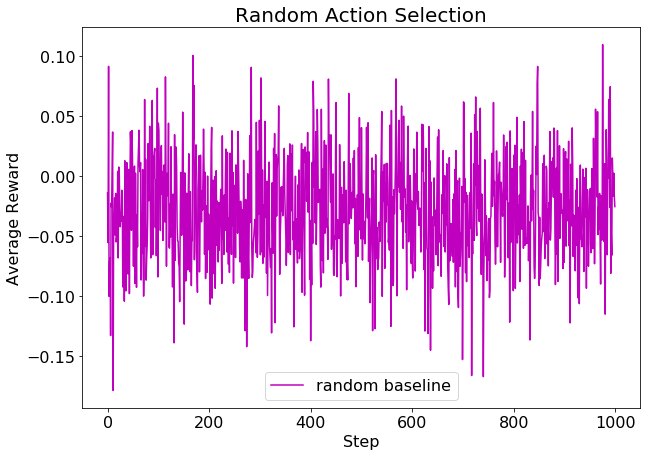

In [12]:
# visualize results
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
plt.plot(rewards_random.mean(0), '-', color=cmap[0], label='random baseline')
plt.legend(loc='best', fontsize=16)
plt.ylabel("Average Reward", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.title("Random Action Selection", fontsize=20)
ax.tick_params(labelsize=16)
plt.show()

### Greedy vs. $\epsilon$-Greedy (2 points)
In our first experiment we will explore the influence of the random action selection probability $\epsilon$ on the evolution of the reward we get.

For this purpose
- First run the *IncrementalSampleAverageMethod* three times with $\epsilon \in \{0.0, 0.01, 0.1\}$
- and compare their performance in one plot.
- Briefly describe your observations.
- Which method will perform best in the long run in terms of cumulative reward and cumulative probability of selecting the best action? How much better will it be? Express your answer quantitatively.

In [13]:
# run experiments
n_steps = 1000
epsilons = [0.0, 0.01, 0.1]
rewards_incremental = {}
performance_incremental = {}
for e in epsilons:
    rewards_incremental[e], performance_incremental[e] = run_experiments(bandit=kArmedBandit, 
                                                                         n_steps=n_steps, 
                                                                         method=IncrementalSampleAverageMethod,
                                                                         epsilon=e)

running IncrementalSampleAverageMethod{'epsilon': 0.0}
done!
running IncrementalSampleAverageMethod{'epsilon': 0.01}
done!
running IncrementalSampleAverageMethod{'epsilon': 0.1}
done!


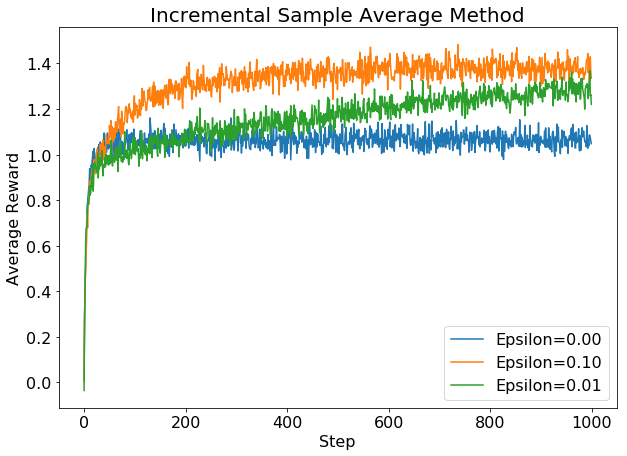

In [14]:
# visualize results
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
for e, r in rewards_incremental.items():
    plt.plot(r.mean(0), '-', label='Epsilon={:04.2f}'.format(e))
plt.legend(loc='best', fontsize=16)
plt.ylabel("Average Reward", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.title("Incremental Sample Average Method", fontsize=20)
ax.tick_params(labelsize=16)
plt.show()

### Comments
We can observe how the agent with $\epsilon$=0.0 perfoms the worst of them all, since it follows a purely greedy policy and does not perform any exploration, thus getting stuck in a local minimum. The agent with $\epsilon$=0.1 initally performs the best thanks to its higher exploration rate, however it looks like the agent with $\epsilon$=0.01 is about to overtake it in terms of obtained average reward. This is due to the fact that, once it finds the best bandit in terms of average reward, it sticks to it more often, exploring other options only 1% of the time and thus getting a higher average reward on most tries.

Average cumulative reward for epsilon=0.00 after 1000 steps: 1056.85
Average cumulative reward for epsilon=0.10 after 1000 steps: 1318.16
Average cumulative reward for epsilon=0.01 after 1000 steps: 1157.80


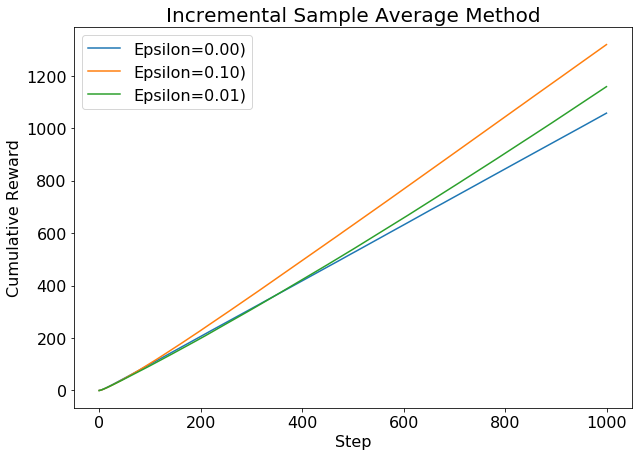

In [15]:
# Average Cumulative rewards
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
for e, r in rewards_incremental.items():
    cumsum = np.cumsum(r.mean(0))
    plt.plot(cumsum, '-', label='Epsilon={:04.2f})'.format(e))
    print('Average cumulative reward for epsilon={:04.2f} after {:d} steps: {:04.2f}'.
          format(e, n_steps, cumsum[-1]))
plt.legend(loc='best', fontsize=16)
plt.ylabel("Cumulative Reward", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.title("Incremental Sample Average Method", fontsize=20)
ax.tick_params(labelsize=16)
plt.show()

### Comments
Again, the agent with $\epsilon$=0.0 perfoms the worst of them all also in terms of cumulative reward. Because the agent with $\epsilon$=0.1 found a good bandit very soon, its cumulative reward is the highest after 1000 steps. However, if we kept the problem running for a longer time, $\epsilon$=0.01 would overtake it, since it explores less and thus it will choose bad bandits less often.

Average performance for epsilon=0.00 after 1000 steps: 71.46% of best reward
Average performance for epsilon=0.10 after 1000 steps: 70.26% of best reward
Average performance for epsilon=0.01 after 1000 steps: 78.88% of best reward


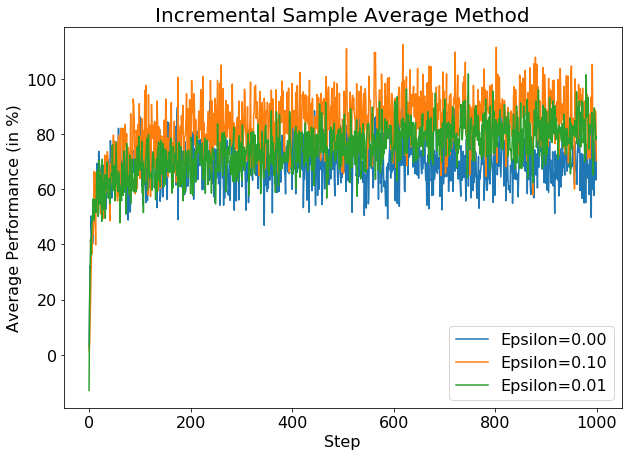

In [16]:
# Average performance as % of best action reward
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
for e, p in performance_incremental.items():
    performance = p.mean(0)
    plt.plot(performance, '-', label='Epsilon={:04.2f}'.format(e))
    print('Average performance for epsilon={:04.2f} after {:d} steps: {:04.2f}% of best reward'.
          format(e, n_steps, performance[-1]))
plt.legend(loc='best', fontsize=16)
plt.ylabel("Average Performance (in %)", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.title("Incremental Sample Average Method", fontsize=20)
ax.tick_params(labelsize=16)
plt.show()

## Comments
This plot looks  very similar to the average reward plot. After 1000 steps, the agent with $\epsilon$=0.01 has started to overtake $\epsilon$=0.1, obtaining an average reward of 78.88% of the best reward compared to 70.26%, respectively. 

### Greedy vs. Optimistic Initial Values (2 points)
In our second experiment we evaluate the performance of another approach to enforce exploration, namely Optimistic Initial Values.

For this purpose
- Run *OptimisticInitialValues* with an initial value of 5.0 for all actions.
- and compare its performance with the *IncrementalSampleAverageMethod* and $\epsilon=0.0$.
- Briefly describe and explain your observations.

In [17]:
# run experiments
rewards_optimistic, _ = run_experiments(bandit=kArmedBandit, method=OptimisticInitialValues,
                                      epsilon=0.0, initial_value=5.0)

running OptimisticInitialValues{'initial_value': 5.0, 'epsilon': 0.0}
done!


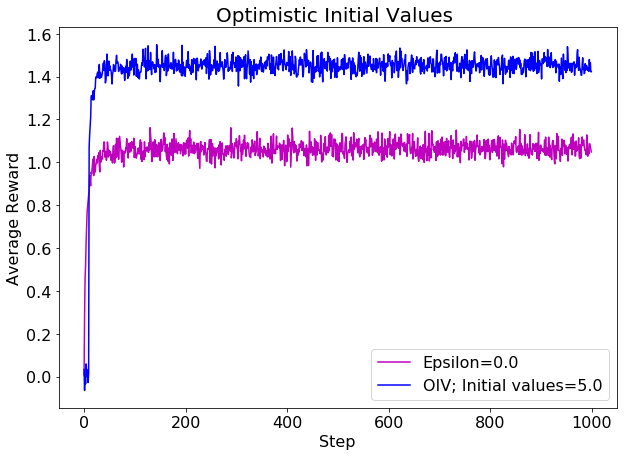

In [18]:
# visualize results
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
plt.plot(rewards_incremental[0.0].mean(0), '-', label='Epsilon=0.0', color=cmap[0])
plt.plot(rewards_optimistic.mean(0), '-', label='OIV; Initial values=5.0'.format(e), color=cmap[1])
plt.legend(loc='best', fontsize=16)
plt.ylabel("Average Reward", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.title("Optimistic Initial Values ", fontsize=20)
ax.tick_params(labelsize=16)
plt.show()

### Comments
We can appreciate how setting optimistic initial values leads to a high exploration rate in the early steps and thus the agent finds a good bandit very soon, whereas the other bandit remain stuck in local minima due to its lack of exploration.

### $\epsilon$-Greedy vs Gradient Bandit (2 points)
In our last experiment we compare $\epsilon$-greedy action selection with the *GradientBandit* algorithm.

For this purpose
- Run the *GradientBandit* algorithm with step sizes $\alpha=0.01$ and $0.1$.
- and compare its performance with the *IncrementalSampleAverageMethod* and $\epsilon=0.1$.
- Briefly describe and explain your observations.

In [19]:
# run experiments
alphas = [0.01, 0.1]
rewards_gradient= {}
for a in alphas:
    rewards_gradient[a], _ = run_experiments(bandit=kArmedBandit, method=GradientBandit,
                                      alpha=a)

running GradientBandit{'alpha': 0.01}
done!
running GradientBandit{'alpha': 0.1}
done!


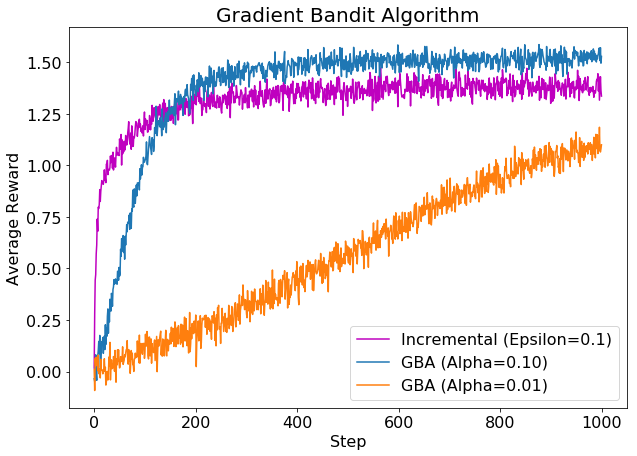

In [20]:
# visualize results
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
plt.plot(rewards_incremental[0.1].mean(0), '-', label='Incremental (Epsilon=0.1)', color=cmap[0])
for a, r in rewards_gradient.items():
    plt.plot(r.mean(0), '-', label='GBA (Alpha={:04.2f})'.format(a))
plt.legend(loc='best', fontsize=16)
plt.ylabel("Average Reward", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.title("Gradient Bandit Algorithm", fontsize=20)
ax.tick_params(labelsize=16)
plt.show()

### Comments
We can see how initaly GBA agents perform worse, but as they converge their performance increases, eventually overtaking the incremental sample average agent. However, a small static step size ($\alpha$=0.01) means that the GBA method estimates get updated very slowly, and thus it takes a long time until its performance catches up with the other agents.

# Non-Stationary Problems (6 points)
Design and conduct an experiment to demonstrate
the difficulties that sample-average methods have with non-stationary problems. Use a
modified version of the 10-armed testbed in which all the $q^∗(a)$ start out equal and
then take independent random walks. Prepare plots like above for an action-value
method using sample averages, incrementally computed by $\alpha=\frac{1}{n}$,
and another action-value method using a constant step-size parameter, $\alpha=0.1$.
Use $\epsilon=0.1$ and runs with 2000 plays (steps). (exercise adopted from book)

<div class="alert alert-info"> 

**Hints:**
<ul>
<li>You can use the code of *kArmedBandit* as a template for this exercise.</li>
<li>You can read about random walks [here](https://en.wikipedia.org/wiki/Random_walk#One-dimensional_random_walk).</li>
<li>Draw the steps of your one-dimensional random walk from the following Gaussian: $\mathcal{N}(0,\,0.5)$</li>
</ul>

</div>

In [21]:
# Implement non-stationary bandit problem
class dynamickArmedBandit(object):
    """
    Specifies a non-stationary k-armed bandit problem

    The agent has to choose from k different actions.
    Taking an action yields a numeric reward specified by a non-stationary probability distribution.
    """

    def __init__(self, k=10):
        """ Constructor """
        # Initial action values are all equal to 0.0
        self.q_star = np.full(k, 0.0)

    def step(self, action):
        """
        Take one step following the given action.

        Parameters
        ----------
           @action: action id (integer in [0, k[)

        Returns
        -------
            the reward for taking this action.
        """
        Ri = self.q_star[action]
        # Compute new q_star by using a random walk in N(0,0.5)
        for a in range(len(self.q_star)):
            self.q_star[a] += (0.5 * np.random.randn())
        return Ri

In [22]:
# Implement action-value method using a constant step-size
class ConstantStepIncrementalSampleAverageMethod(IncrementalSampleAverageMethod):
    """
    Incremental Implementation of Sample Average Method wiht a constant step size
    Extends IncrementalSampleAverageMethod

    Parameters
    ----------
        @k: number of possible actions (integer)
        @epsilon: probability for selecting a random action (float in [0, 1])
        @step_size: step size in action estimate update rule
    """

    def __init__(self, k=10, epsilon=0.0, step_size=0.0):
        """ Constructor """
        if isinstance(k, int) and k > 0:
            self.k = k
        else:
            raise ValueError('k must be a positive Integer')
        if 0 <= epsilon <= 1 and 0 <= step_size <= 1:
            self.step_size = step_size
            self.eps = epsilon
        else:
            raise ValueError('Epsilon and Step size must be between 0 and 1')
        # Action estimates
        self.Qa = np.zeros(k)

    def update_estimates(self, action, reward):
        """ update action value estimate """
        Qa_update = self.step_size * (reward - self.Qa[action])
        self.Qa[action] += Qa_update

In [23]:
# run experiments
rewards_nonstat_dynamic_step, perf_nonstat_dynamic_step = run_experiments(bandit=dynamickArmedBandit,
                                              n_steps=2000,
                                              method=IncrementalSampleAverageMethod,
                                              epsilon=0.1)

rewards_nonstat_constant_step, perf_nonstat_constant_step = run_experiments(bandit=dynamickArmedBandit,
                                                n_steps=2000,
                                                method=ConstantStepIncrementalSampleAverageMethod,
                                                epsilon=0.1, step_size=0.1)

running IncrementalSampleAverageMethod{'epsilon': 0.1}
done!
running ConstantStepIncrementalSampleAverageMethod{'step_size': 0.1, 'epsilon': 0.1}
done!


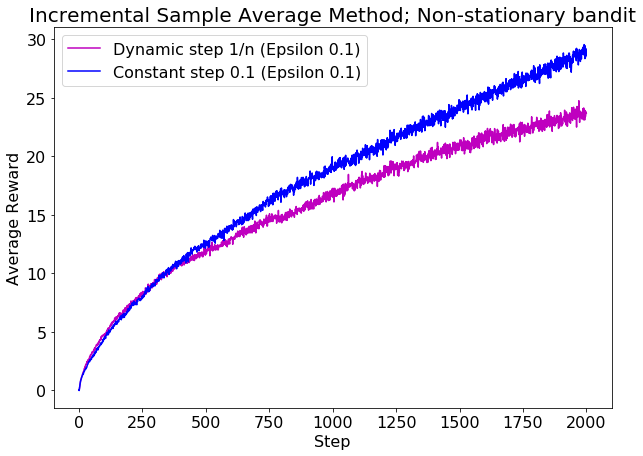

In [24]:
# visualize results
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
plt.plot(rewards_nonstat_dynamic_step.mean(0), '-', label='Dynamic step 1/n (Epsilon 0.1)',
         color=cmap[0])
plt.plot(rewards_nonstat_constant_step.mean(0), '-', label='Constant step 0.1 (Epsilon 0.1)',
         color=cmap[1])
plt.legend(loc='best', fontsize=16)
plt.ylabel("Average Reward", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.title("Incremental Sample Average Method; Non-stationary bandit", fontsize=20)
ax.tick_params(labelsize=16)
plt.show()

Average performance for dynamic step 1/n (Epsilon 0.1) after 2000 steps (10 last steps): 66.25% of best reward
Average performance for constant step 0.1 (Epsilon 0.1) after 2000 steps (10 last steps): 82.41% of best reward


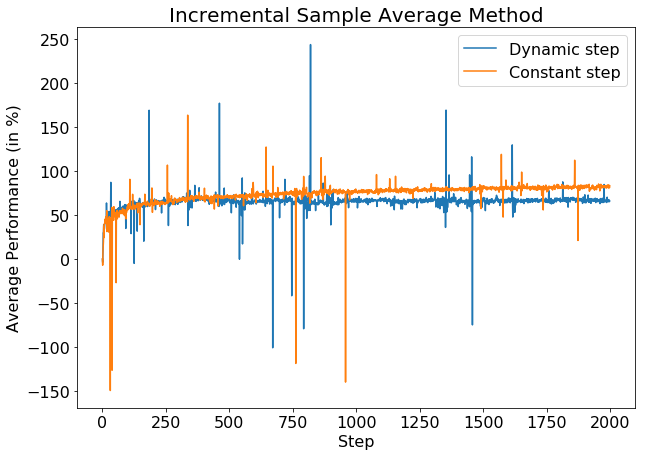

In [28]:
# Average performance as % of best action reward
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
plt.plot(perf_nonstat_dynamic_step.mean(0), '-', label='Dynamic step'.format(e))
print('Average performance for dynamic step 1/n (Epsilon 0.1) after 2000 steps (10 last steps): {:04.2f}% of best reward'.
          format(np.mean(perf_nonstat_dynamic_step.mean(0)[-10:])))
plt.plot(perf_nonstat_constant_step.mean(0), '-', label='Constant step'.format(e))
print('Average performance for constant step 0.1 (Epsilon 0.1) after 2000 steps (10 last steps): {:04.2f}% of best reward'.
          format(np.mean(perf_nonstat_constant_step.mean(0)[-10:])))
plt.legend(loc='best', fontsize=16)
plt.ylabel("Average Performance (in %)", fontsize=16)
plt.xlabel("Step", fontsize=16)
plt.title("Incremental Sample Average Method", fontsize=20)
ax.tick_params(labelsize=16)
plt.show()

### Comment
Now we are considering a non-stationary problems in which bandits randomly update their rewards on each step. Using an agent with a dynamic step of 1/n yields mediocre results with an average obtained reward of 66.25% of the best possible reward. This is because all past rewards are taken into account equally when updating reward estimates, but, due to their non-stationary nature, past rewards are not good indicators of future ones and they pollute the new estimate.

On the other hand, using a constant learning step of $\alpha$=0.1 with a high exploratory rate of 10% ($\epsilon$=0.01) yields good results in this case. A constant step weights recent rewards more heavily, which is beneficial in this case where the latest rewards give better insight on the current reward level of a given bandit. Moreover, given that one of the bandits might end up having a very postive random walk (resulting in a high reward), a high exploratory rate makes it possible to find it and thus obtain a good policy.